In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import os
import torch
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import itertools

def collect_columns(dicts):
    # Initialize an empty dictionary to store the result
    result = {}

    # Loop over each dictionary in the list
    for d in dicts:
        # Loop over each key in the current dictionary
        for key in d.keys():
            # If the key is not already in the result, add it with an empty list
            if key not in result:
                result[key] = [None]*len(dicts)

        # Loop over each key in the result
        for key in result.keys():
            # If the key is in the current dictionary, add its value to the list
            # If not, add None
            if key in d:
                result[key][dicts.index(d)] = d[key]

    # Return the result
    return result


def merge_files(dir_path, skip_pt=True):
    # Initialize an empty dictionary to store the result
    result = {}

    # Walk through the directory
    for file in (os.listdir(dir_path)):
        # Check if the file has one of the required extensions
        if file.endswith(('.pickle', '.p')) or (file.endswith('.pt') and not skip_pt):
            # Construct the full file path
            file_path = os.path.join(dir_path, file)

            # Load the file content
            if file.endswith('.pt'):
                content = {'model_state': torch.load(file_path)}
            else:  # '.pickle' or '.p'
                with open(file_path, 'rb') as f:
                    content = pickle.load(f)

            # If the content is a dictionary, merge it with the result
            # Otherwise, add it under its filename
            if isinstance(content, dict):
                result.update(content)
            else:
                result[file] = content

    # Return the result
    return result


In [3]:
tags = ['swip_multiple_parameters']
data_dicts = []
for t in tags:
	cur_path = os.path.join('data',t)
	for f_p in os.listdir(cur_path):
		data_path=os.path.join(cur_path,f_p)
		data_dicts.append(merge_files(data_path))
data = collect_columns(data_dicts)
df = pd.DataFrame(data)
df = df.dropna(subset=['performance_mat.p'])

df=df[df['checkpoint_step.pickle']==df['checkpoint_step.pickle'].max()]
df


,seed_number,torch_seed_number,entropy_dependent_lr,homogeneous_lr,tag,n_task,batch_size,n_steps,n_epochs,num_workers,...,n_f_steps,lr,checkpoint,input_size,number_of_classes,dir_name,dest_path,kwargs,checkpoint_step.pickle,performance_mat.p
38,42,28,False,True,swip_multiple_parameters,6,15,None,10,1,...,None,0.0,0,784,10,d_170_7093,data/swip_multiple_parameters/d_170_7093,"{'a': 1e-09, 'b': 1e-08, 'r': 0.4, 'total_lr':...",5.0,"[[0.07999999821186066, 0.0, 0.0, 0.0, 0.0, 0.0..."
39,42,28,False,True,swip_multiple_parameters,6,15,None,10,1,...,None,0.0,0,784,10,d_171_4892,data/swip_multiple_parameters/d_171_4892,"{'a': 1e-07, 'b': 1e-06, 'r': 0.25, 'total_lr'...",5.0,"[[0.07999999821186066, 0.0, 0.0, 0.0, 0.0, 0.0..."
40,42,28,False,True,swip_multiple_parameters,6,15,None,10,1,...,None,0.0035,0,784,10,d_172_3738,data/swip_multiple_parameters/d_172_3738,"{'a': 1e-08, 'b': 0.01, 'r': 0.35, 'total_lr':...",5.0,"[[0.36629998683929443, 0.0, 0.0, 0.0, 0.0, 0.0..."
41,42,28,False,False,swip_multiple_parameters,6,15,None,10,1,...,None,"[[1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e...",0,784,10,d_173_5334,data/swip_multiple_parameters/d_173_5334,"{'a': 1e-14, 'b': 1e-10, 'r': 0.05, 'total_lr'...",5.0,"[[0.07999999821186066, 0.0, 0.0, 0.0, 0.0, 0.0..."
42,42,28,False,True,swip_multiple_parameters,6,15,None,10,1,...,None,0.0,0,784,10,d_174_1237,data/swip_multiple_parameters/d_174_1237,"{'a': 1e-12, 'b': 1e-07, 'r': 0.45, 'total_lr'...",5.0,"[[0.07999999821186066, 0.0, 0.0, 0.0, 0.0, 0.0..."
43,42,28,False,True,swip_multiple_parameters,6,15,None,10,1,...,None,0.001509,0,784,10,d_175_7362,data/swip_multiple_parameters/d_175_7362,"{'a': 1e-05, 'b': 0.01, 'r': 0.15, 'total_lr':...",5.0,"[[0.39340001344680786, 0.0, 0.0, 0.0, 0.0, 0.0..."
44,42,28,False,False,swip_multiple_parameters,6,15,None,10,1,...,None,"[[1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e...",0,784,10,d_176_6751,data/swip_multiple_parameters/d_176_6751,"{'a': 1e-14, 'b': 1e-10, 'r': 0.45, 'total_lr'...",5.0,"[[0.07999999821186066, 0.0, 0.0, 0.0, 0.0, 0.0..."
45,42,28,False,True,swip_multiple_parameters,6,15,None,10,1,...,None,0.0,0,784,10,d_177_8377,data/swip_multiple_parameters/d_177_8377,"{'a': 1e-14, 'b': 1e-10, 'r': 0.05, 'total_lr'...",5.0,"[[0.07999999821186066, 0.0, 0.0, 0.0, 0.0, 0.0..."
46,42,28,False,True,swip_multiple_parameters,6,15,None,10,1,...,None,0.0,0,784,10,d_178_6466,data/swip_multiple_parameters/d_178_6466,"{'a': 1e-13, 'b': 1e-12, 'r': 0.45, 'total_lr'...",5.0,"[[0.07999999821186066, 0.0, 0.0, 0.0, 0.0, 0.0..."
47,42,28,False,False,swip_multiple_parameters,6,15,None,10,1,...,None,"[[1e-07, 1e-07, 1e-07, 1e-07, 1e-07, 1e-07, 1e...",0,784,10,d_179_9574,data/swip_multiple_parameters/d_179_9574,"{'a': 1e-14, 'b': 1e-07, 'r': 0.25, 'total_lr'...",5.0,"[[0.07999999821186066, 0.0, 0.0, 0.0, 0.0, 0.0..."


Comparison between group False and group True:
Average corrected p-value: nan


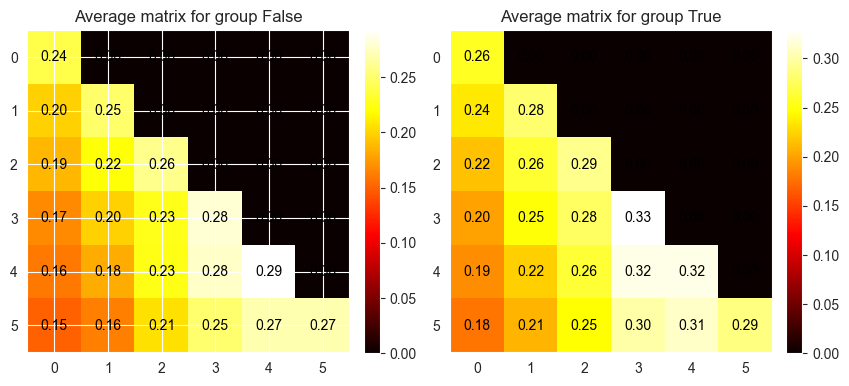

In [4]:
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import itertools
# Assuming 'group' is the column with group identifiers
group_condition = 'homogeneous_lr'
grouped = df.groupby(group_condition)

# Calculate the average 2D matrix for each group
average_matrices = grouped['performance_mat.p'].apply(lambda g: np.mean(np.array(g.tolist()), axis=0))

# Create a dictionary to store matrices of p-values for each pair of groups
p_values = {}

# Perform t-test on each pair of corresponding elements in the 2D matrices of each pair of groups
for group1, group2 in itertools.combinations(grouped.groups.keys(), 2):
    matrices1 = grouped.get_group(group1)['performance_mat.p'].tolist()
    matrices2 = grouped.get_group(group2)['performance_mat.p'].tolist()

    # Check if the individual matrices within each group have the same dimensions
    if np.shape(matrices1[0]) != np.shape(matrices2[0]):
        print(f"Skipping comparison between group {group1} and group {group2} due to different matrix shapes.")
        continue

    p_val_matrix = np.empty(np.shape(matrices1[0]))
    for i in range(p_val_matrix.shape[0]):
        for j in range(p_val_matrix.shape[1]):
            _, p_val_matrix[i, j] = ttest_ind([mat[i, j] for mat in matrices1], [mat[i, j] for mat in matrices2])

    # Apply Bonferroni correction
    p_val_matrix *= np.size(p_val_matrix)
    p_val_matrix[p_val_matrix > 1] = 1  # cap p-values at 1 after Bonferroni correction

    p_values[(group1, group2)] = p_val_matrix

#  Plot the average matrices and print the average p-value for each pair of groups
for group1, group2 in p_values.keys():
    print(f"Comparison between group {group1} and group {group2}:")
    print(f"Average corrected p-value: {np.mean(p_values[(group1, group2)])}")

    # Plot the average matrices
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    im1 = axs[0].imshow(average_matrices.loc[group1], cmap='hot', interpolation='nearest')
    axs[0].set_title(f'Average matrix for group {group1}')
    fig.colorbar(im1, ax=axs[0], fraction=0.046, pad=0.04)  # Add a colorbar to the first subplot

    # Display average values on each entry of the matrix
    for (j,i),label in np.ndenumerate(average_matrices.loc[group1]):
        axs[0].text(i,j,f"{label:.2f}",ha='center',va='center', color='k')

    im2 = axs[1].imshow(average_matrices.loc[group2], cmap='hot', interpolation='nearest')
    axs[1].set_title(f'Average matrix for group {group2}')
    fig.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04)  # Add a colorbar to the second subplot

    # Display average values on each entry of the matrix
    for (j,i),label in np.ndenumerate(average_matrices.loc[group2]):
        axs[1].text(i,j,f"{label:.2f}",ha='center',va='center', color='k')
    plt.grid(False)
    plt.show()


   homogeneous_lr  trial  accuracy
0           False      1  0.149917
1           False      2  0.163117
2           False      3  0.205657
3           False      4  0.250967
4           False      5  0.270367
5           False      6  0.270010
    homogeneous_lr  trial  accuracy
6             True      1  0.177927
7             True      2  0.209490
8             True      3  0.246547
9             True      4  0.300753
10            True      5  0.310853
11            True      6  0.287167


C:\Users\ninit\AppData\Local\Temp\ipykernel_7760\4238188333.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_df = grouped.mean().reset_index()
C:\Users\ninit\AppData\Local\Temp\ipykernel_7760\4238188333.py:28: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  std_df = grouped.std().reset_index()


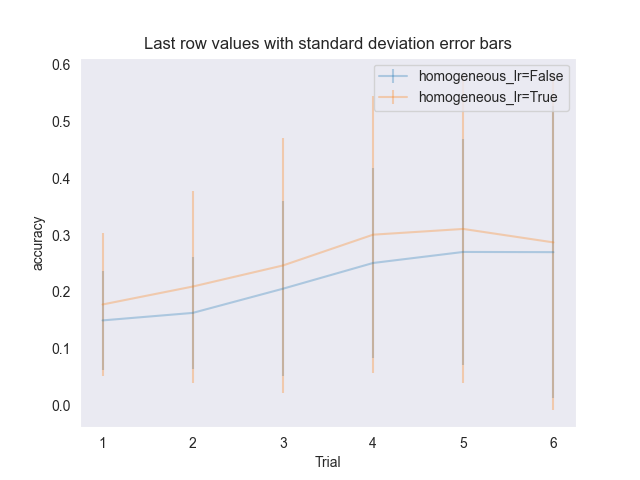

In [21]:
import re

# Extract the last row from each matrix and create a new DataFrame
last_row_df = df.copy()

last_row_df['last_row'] = df['performance_mat.p'].apply(lambda x: x[-1, :])
last_row_df = last_row_df['last_row'].apply(pd.Series)

last_row_df.columns = [f"trial_{i+1}" for i in last_row_df.columns]

# Add the condition columns to the new DataFrame
condition_columns = [group_condition]
for col in condition_columns:
    last_row_df[col] = df[col]
last_row_df['kwargs']=df['kwargs']
# Melt the DataFrame to a long format suitable for plotting
last_row_df = last_row_df.melt(id_vars=condition_columns+['kwargs'], var_name='trial', value_name='accuracy')




# Extract numeric trial number from the 'trial' column
last_row_df['trial'] = last_row_df['trial'].apply(lambda x: int(re.search(r'\d+', x).group()))
# Group by condition and trial
grouped = last_row_df.groupby(condition_columns + ['trial'])
# Calculate mean and std for each group
mean_df = grouped.mean().reset_index()
std_df = grouped.std().reset_index()
# Extract unique group names
group_columns =  df.groupby(condition_columns).size().reset_index().iloc[:, :-1]
fig,ax=plt.subplots()
# Loop over each unique group
for _, row in group_columns.iterrows():
    condition = pd.Series([True]*len(mean_df))

    # Create a boolean mask for each condition
    for col in condition_columns:
        condition = condition & (mean_df[col] == row[col])

    group_mean_df = mean_df[condition]
    group_std_df = std_df[condition]

    # Create a label for the plot
    label = ', '.join([f'{col}={row[col]}' for col in condition_columns])
    print(group_mean_df)
    ax.errorbar(group_mean_df['trial'], group_mean_df['accuracy'], yerr=group_std_df['accuracy'], label=label,alpha=0.3)

plt.xlabel('Trial')
plt.ylabel('accuracy')
plt.title('Last row values with standard deviation error bars')
plt.legend()
plt.grid(False)
plt.show()



In [24]:
last_row_df['a']=last_row_df['kwargs'].apply(lambda x:x['a'])
last_row_df['b']=last_row_df['kwargs'].apply(lambda x:x['b'])
last_row_df['r']=last_row_df['kwargs'].apply(lambda x:x['r'])
last_row_df['total_lr']=last_row_df['kwargs'].apply(lambda x:x['total_lr'])
last_row_df


,homogeneous_lr,kwargs,trial,accuracy,a,b,r,total_lr
0,True,"{'a': 1e-09, 'b': 1e-08, 'r': 0.4, 'total_lr':...",1,0.0800,1.000000e-09,1.000000e-08,0.40,4.600000e-09
1,True,"{'a': 1e-07, 'b': 1e-06, 'r': 0.25, 'total_lr'...",1,0.0799,1.000000e-07,1.000000e-06,0.25,3.250000e-07
2,True,"{'a': 1e-08, 'b': 0.01, 'r': 0.35, 'total_lr':...",1,0.2498,1.000000e-08,1.000000e-02,0.35,3.500006e-03
3,False,"{'a': 1e-14, 'b': 1e-10, 'r': 0.05, 'total_lr'...",1,0.0800,1.000000e-14,1.000000e-10,0.05,5.009500e-12
4,True,"{'a': 1e-12, 'b': 1e-07, 'r': 0.45, 'total_lr'...",1,0.0800,1.000000e-12,1.000000e-07,0.45,4.500055e-08
...,...,...,...,...,...,...,...,...
355,True,"{'a': 1e-12, 'b': 0.0001, 'r': 0.2, 'total_lr'...",6,0.1321,1.000000e-12,1.000000e-04,0.20,2.000000e-05
356,False,"{'a': 1e-13, 'b': 1e-11, 'r': 0.2, 'total_lr':...",6,0.0847,1.000000e-13,1.000000e-11,0.20,2.080000e-12
357,True,"{'a': 1e-13, 'b': 1e-11, 'r': 0.2, 'total_lr':...",6,0.0847,1.000000e-13,1.000000e-11,0.20,2.080000e-12
358,False,"{'a': 1e-14, 'b': 1e-13, 'r': 0.2, 'total_lr':...",6,0.0847,1.000000e-14,1.000000e-13,0.20,2.800000e-14


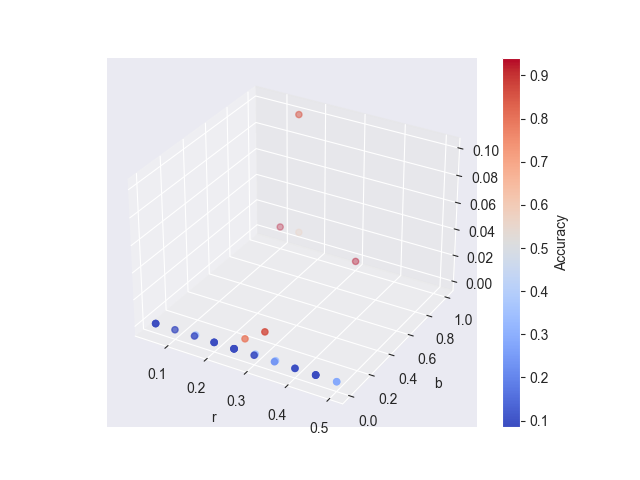

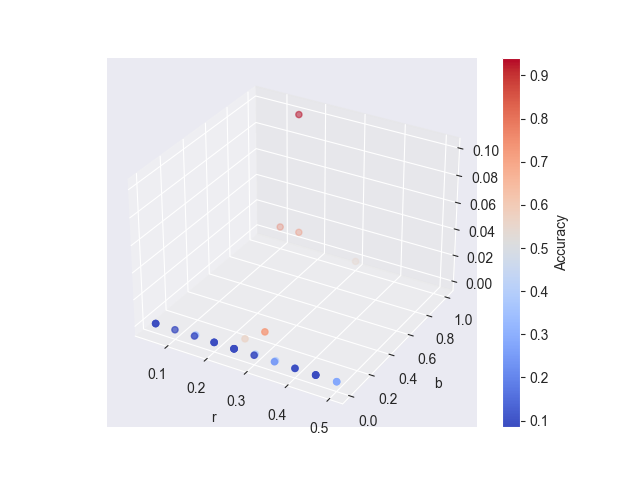

In [35]:

# creating 3d plot using matplotlib
# in python
 
# for creating a responsive plot
%matplotlib widget
 
# importing required libraries
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
trial=6


cur_df= last_row_df[last_row_df['trial']==trial]


# normalize accuracy for color mapping
norm = plt.Normalize(cur_df['accuracy'].min(), cur_df['accuracy'].max())

def plot_3d(input_df):
    for i in [True,False]:
        cur_df=input_df[input_df['homogeneous_lr']==i]
        # create the 3D plot
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        # scatter plot with color gradient based on accuracy
        sc = ax.scatter(cur_df['r'], cur_df['b'],cur_df['a'], c=cur_df['accuracy'], norm=norm, cmap='coolwarm')

        # add labels to the axes
        ax.set_xlabel('r')
        ax.set_ylabel('b')
        ax.set_zlabel('a')

        # add a colorbar to represent the accuracy gradient
        fig.colorbar(sc, ax=ax, label='Accuracy')

        # show the plot
        plt.show()
plot_3d(cur_df)